In [94]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score, classification_report
import scikitplot as skplt
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasRegressor
from kerastuner.engine.hyperparameters import HyperParameters
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.metrics import AUC
import tensorflow

# Data pre-process and EDA

In [2]:
# read games data
games = pd.read_csv('games.csv')

In [3]:
games.columns

Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner',
       'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3',
       't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHer

In [4]:
games.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [5]:
# drop useless columns

games.drop(columns=['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 
                    't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4','t2_ban5',
                    'creationTime', 'seasonId', 'gameId', 'creationTime'], inplace=True)

In [6]:
# set team id to color
def team_to_color(x):
    if x == 1:
        return 'b'
    elif x == 2:
        return 'r'
    else:
        return np.NaN


games['winner'] = games['winner'].apply(team_to_color)
games['firstBlood'] = games['firstBlood'].apply(team_to_color)
games['firstTower'] = games['firstTower'].apply(team_to_color)
games['firstInhibitor'] = games['firstInhibitor'].apply(team_to_color)
games['firstBaron'] = games['firstBaron'].apply(team_to_color)
games['firstDragon'] = games['firstDragon'].apply(team_to_color)
games['firstRiftHerald'] = games['firstRiftHerald'].apply(team_to_color)

In [7]:
games

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1949,b,r,b,b,b,b,r,8,12,...,14,4,412,4,3,5,0,0,1,1
1,1851,b,b,b,b,NaN,b,b,119,7,...,4,14,92,4,7,2,0,0,0,0
2,1493,b,r,b,b,b,r,NaN,18,4,...,4,11,22,7,4,2,0,0,1,0
3,1758,b,b,b,b,b,b,NaN,57,4,...,4,14,22,4,7,0,0,0,0,0
4,2094,b,r,b,b,b,b,NaN,19,4,...,4,12,51,4,7,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,r,b,r,r,NaN,r,NaN,19,12,...,3,4,79,11,4,10,2,0,4,0
51486,3304,r,b,b,r,r,r,r,90,4,...,4,12,45,14,4,11,7,4,4,1
51487,2156,r,r,r,r,NaN,b,NaN,141,11,...,12,4,99,14,4,10,2,0,2,0
51488,1475,r,r,r,r,NaN,r,NaN,121,11,...,12,4,11,11,4,11,3,0,1,0


In [8]:
# read champ data

champ1 = pd.read_json('champion_info.json')
champ2 = pd.read_json('champion_info_2.json')


champ1 = json_normalize(champ1.data)
champ2 = json_normalize(champ2.data)

In [9]:
# drop columns and merge
champ1.drop(columns = ['title', 'key'], inplace=True)
champ2.drop(columns = ['title', 'key', 'name'], inplace=True)
champ = champ1.merge(champ2, on='id')

In [11]:
# clean up tags of champ

champ[['tag1','tag2']] = champ['tags'].apply(','.join).str.split(',', expand=True)
champ.drop(columns=['tags'], inplace=True)
champ.replace({'tag2':None}, np.NaN, inplace=True)

In [12]:
# set index
champ.set_index('id', inplace=True)

In [126]:
champ.head()

,name,tag1,tag2
id,,,
1,Annie,Mage,NaN
10,Kayle,Fighter,Support
101,Xerath,Mage,Assassin
102,Shyvana,Fighter,Tank
103,Ahri,Mage,Assassin


In [14]:
#get counts of type of chara in a game for each team
def get_count(occ, col1, col2, col3, col4, col5):
    cnt=0
    for i in [col1, col2, col3, col4, col5] :
        if (champ[champ.index == i]['tag1'].item() == occ) or (champ[champ.index == i]['tag2'].item() == occ):
            cnt +=1
    return cnt

In [15]:
# Fighter in b team
games['num_of_Fighter_b'] \
= games.apply(lambda x:get_count('Fighter', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

# Tank in b team
games['num_of_Tank_b'] \
= games.apply(lambda x:get_count('Tank', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

# Mage in b team
games['num_of_Mage_b'] \
= games.apply(lambda x:get_count('Mage', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

# Assassin in b team
games['num_of_Assassin_b'] \
= games.apply(lambda x:get_count('Assassin', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

# Support in b team
games['num_of_Support_b'] \
= games.apply(lambda x:get_count('Support', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

# Marksman in b team
games['num_of_Marksman_b'] \
= games.apply(lambda x:get_count('Marksman', x.t1_champ1id, x.t1_champ2id, x.t1_champ3id, x.t1_champ4id, x.t1_champ5id), 
         axis=1)

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


In [16]:
# Fighter in r team
games['num_of_Fighter_r'] \
= games.apply(lambda x:get_count('Fighter', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

# Tank in r team
games['num_of_Tank_r'] \
= games.apply(lambda x:get_count('Tank', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

# Mage in r team
games['num_of_Mage_r'] \
= games.apply(lambda x:get_count('Mage', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

# Assassin in r team
games['num_of_Assassin_r'] \
= games.apply(lambda x:get_count('Assassin', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

# Support in r team
games['num_of_Support_r'] \
= games.apply(lambda x:get_count('Support', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

# Marksman in r team
games['num_of_Marksman_r'] \
= games.apply(lambda x:get_count('Marksman', x.t2_champ1id, x.t2_champ2id, x.t2_champ3id, x.t2_champ4id, x.t2_champ5id), 
         axis=1)

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


In [17]:
games.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,num_of_Mage_b,num_of_Assassin_b,num_of_Support_b,num_of_Marksman_b,num_of_Fighter_r,num_of_Tank_r,num_of_Mage_r,num_of_Assassin_r,num_of_Support_r,num_of_Marksman_r
0,1949,b,r,b,b,b,b,r,8,12,...,4,1,1,1,3,1,0,1,1,2
1,1851,b,b,b,b,NaN,b,b,119,7,...,0,3,1,1,4,2,1,2,1,0
2,1493,b,r,b,b,b,r,NaN,18,4,...,3,3,1,1,3,0,1,1,2,2
3,1758,b,b,b,b,b,b,NaN,57,4,...,3,1,1,1,3,1,1,2,2,1
4,2094,b,r,b,b,b,b,NaN,19,4,...,2,1,2,2,2,1,2,2,1,1


In [18]:
#spell data

spell = pd.read_json('summoner_spell_info.json')
spell = json_normalize(spell.data)
spell.set_index('id', inplace=True)
spell.head()

,summonerLevel,name,key,description
id,,,,
1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
11,10,Smite,SummonerSmite,Deals 390-1000 true damage (depending on champ...
12,6,Teleport,SummonerTeleport,"After channeling for 4.5 seconds, teleports yo..."
13,1,Clarity,SummonerMana,Restores 50% of your champion's maximum Mana. ...
14,10,Ignite,SummonerDot,"Ignites target enemy champion, dealing 70-410 ..."


In [19]:
# champ id to name
def toname(id,data):
    return data['name'][id]
    
champCols = ['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']


for i in champCols:
    games[i] = games[i].apply(lambda x: toname(x, champ))


In [127]:
spell.head()

,summonerLevel,name,key,description
id,,,,
1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
11,10,Smite,SummonerSmite,Deals 390-1000 true damage (depending on champ...
12,6,Teleport,SummonerTeleport,"After channeling for 4.5 seconds, teleports yo..."
13,1,Clarity,SummonerMana,Restores 50% of your champion's maximum Mana. ...
14,10,Ignite,SummonerDot,"Ignites target enemy champion, dealing 70-410 ..."


In [21]:
# spell id to name
spellCols = ['t1_champ1_sum1','t1_champ1_sum2','t1_champ2_sum1','t1_champ2_sum2','t1_champ3_sum1','t1_champ3_sum2',
             't1_champ4_sum1','t1_champ4_sum2','t1_champ5_sum1','t1_champ5_sum2','t2_champ1_sum1','t2_champ1_sum2',
             't2_champ2_sum1','t2_champ2_sum2','t2_champ3_sum1','t2_champ3_sum2','t2_champ4_sum1','t2_champ4_sum2',
             't2_champ5_sum1','t2_champ5_sum2']

for i in spellCols:
    games[i] = games[i].apply(lambda x: toname(x,spell))
    

In [22]:
games.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,num_of_Mage_b,num_of_Assassin_b,num_of_Support_b,num_of_Marksman_b,num_of_Fighter_r,num_of_Tank_r,num_of_Mage_r,num_of_Assassin_r,num_of_Support_r,num_of_Marksman_r
0,1949,b,r,b,b,b,b,r,Vladimir,Teleport,...,4,1,1,1,3,1,0,1,1,2
1,1851,b,b,b,b,NaN,b,b,Draven,Heal,...,0,3,1,1,4,2,1,2,1,0
2,1493,b,r,b,b,b,r,NaN,Tristana,Flash,...,3,3,1,1,3,0,1,1,2,2
3,1758,b,b,b,b,b,b,NaN,Maokai,Flash,...,3,1,1,1,3,1,1,2,2,1
4,2094,b,r,b,b,b,b,NaN,Warwick,Flash,...,2,1,2,2,2,1,2,2,1,1


In [23]:
games.dtypes

gameDuration           int64
winner                object
firstBlood            object
firstTower            object
firstInhibitor        object
firstBaron            object
firstDragon           object
firstRiftHerald       object
t1_champ1id           object
t1_champ1_sum1        object
t1_champ1_sum2        object
t1_champ2id           object
t1_champ2_sum1        object
t1_champ2_sum2        object
t1_champ3id           object
t1_champ3_sum1        object
t1_champ3_sum2        object
t1_champ4id           object
t1_champ4_sum1        object
t1_champ4_sum2        object
t1_champ5id           object
t1_champ5_sum1        object
t1_champ5_sum2        object
t1_towerKills          int64
t1_inhibitorKills      int64
t1_baronKills          int64
t1_dragonKills         int64
t1_riftHeraldKills     int64
t2_champ1id           object
t2_champ1_sum1        object
t2_champ1_sum2        object
t2_champ2id           object
t2_champ2_sum1        object
t2_champ2_sum2        object
t2_champ3id   

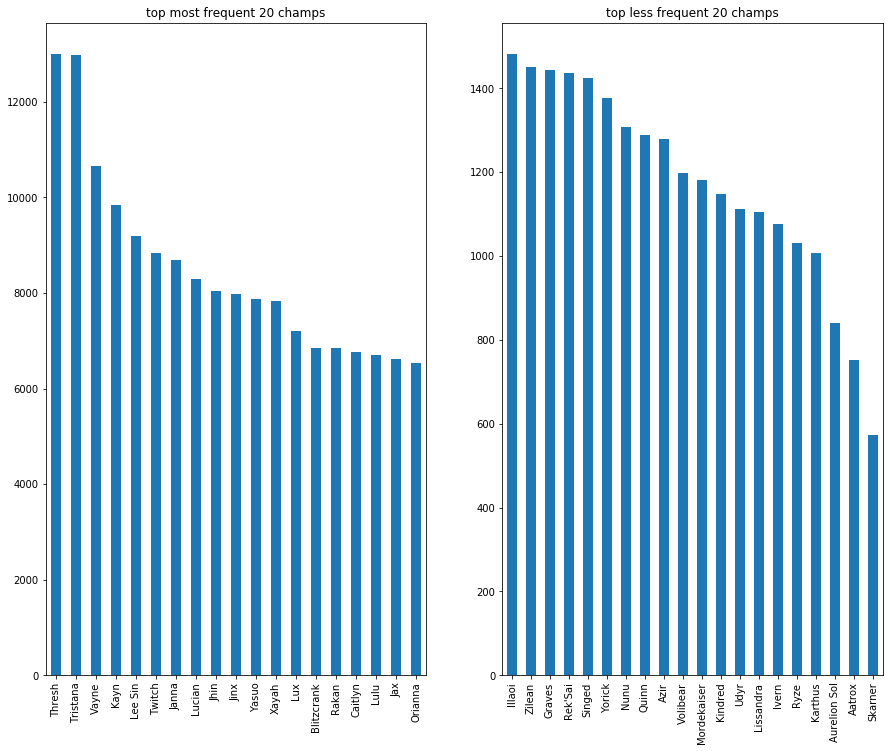

In [24]:
# counts for the champ

champ_cnt = games[champCols].apply(pd.Series.value_counts).sum(axis=1)

fig, axes = plt.subplots(ncols=2, sharey=False, figsize=(15,12))

champ_cnt.sort_values(ascending = False)[:19].plot(kind='bar', ax=axes[0], title = 'top most frequent 20 champs')

champ_cnt.sort_values(ascending = False)[-20:].plot(kind='bar', ax = axes[1], title = 'top less frequent 20 champs')


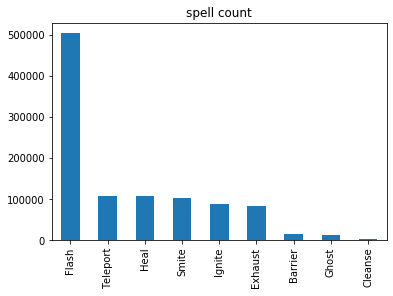

In [25]:
# counts for the spell

spell_cnt = games[spellCols].apply(pd.Series.value_counts).sum(axis=1)

spell_cnt.sort_values(ascending = False).plot(kind='bar', title = 'spell count')


# model

Label encode and onehot encoder

In [26]:
# cat to numerice
df = games.fillna('o')
df.shape
df.replace({'b':1, 'r':0, 'o':2}, inplace = True)

In [27]:
# X and Y def
Y = df['winner'].values

X = df.drop(columns = 'winner')

In [28]:
# cat columns
categorical_cols = X.dtypes[X.dtypes==object].index

categorical_mask = X.dtypes==object

In [29]:
# label encoder
le = LabelEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

In [30]:
X[categorical_cols] = X[categorical_cols].astype(object) 

In [31]:
# one hot encoder
ohe = OneHotEncoder(sparse=False)

X = ohe.fit_transform(X)
#Y = ohe.fit_transform(Y)

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [32]:
X.shape

(51490, 4315)

In [33]:
Y.shape

(51490,)

Feature selection

In [34]:
# feature selection

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)

Text(0.5, 1.0, 'coef of features')

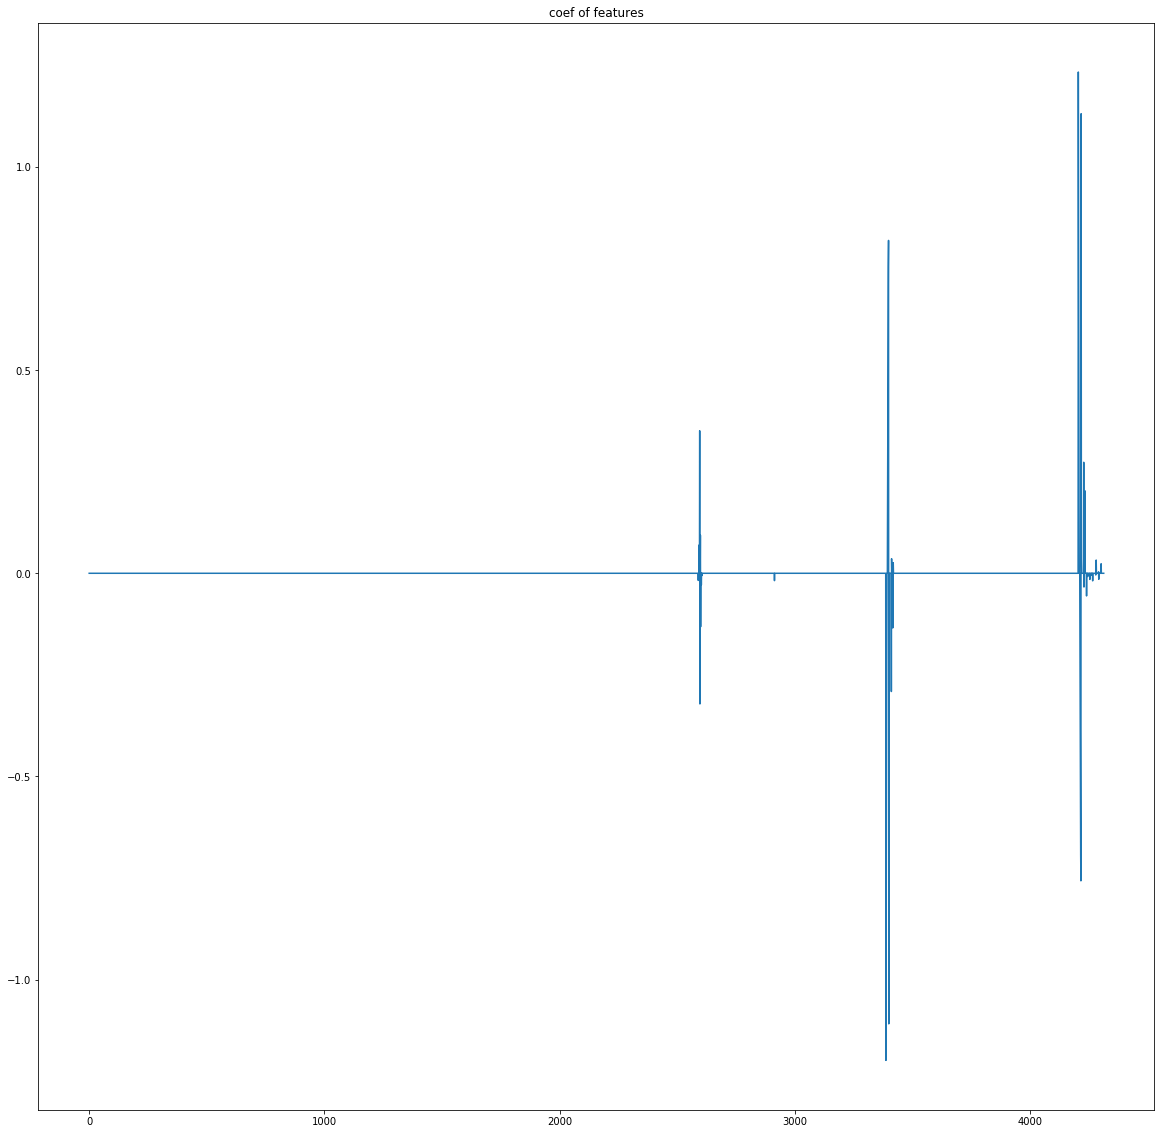

In [35]:
plt.figure(figsize = (20,20))
plt.plot(range(4315),lsvc.coef_[0,:])
plt.title('coef of features')

In [36]:
# feature selection

model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
X.shape

(51490, 49)

In [37]:
X.shape

(51490, 49)

In [38]:
Y.shape

(51490,)

1. KNN 

In [39]:
# normalize

scaler = StandardScaler()
scaler.fit
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state=42, stratify = Y)


# grid search
knn = KNeighborsClassifier()
n = np.arange(1,10)
param_knn = {'n_neighbors':n}

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
                           
knn_cv = RandomizedSearchCV(knn, param_knn, cv=inner_cv, scoring='roc_auc')
knn_cv.fit(X_train, Y_train)
print('best param is {0}'.format(knn_cv.best_params_))
print('best score is {0}'.format(knn_cv.best_score_))
print('-------------')

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


best param is {'n_neighbors': 9}
best score is 0.9932375371429099
-------------


In [40]:
knn_score = cross_val_score(knn_cv, X=X_train, y=Y_train, cv=outer_cv, scoring='roc_auc')

/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/teddy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is

In [41]:
knn_score

array([0.99225149, 0.99371475, 0.99381306, 0.99317091])

In [42]:
Y_pred_knn = knn_cv.predict(X_test)

In [43]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_knn)

print("The AUC is:", auc(fpr, tpr))
print('threshold:', thresholds)
print("")
print(classification_report(Y_test, Y_pred_knn))

The AUC is: 0.9609693249005257
threshold: [2 1 0]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10165
           1       0.96      0.96      0.96     10431

    accuracy                           0.96     20596
   macro avg       0.96      0.96      0.96     20596
weighted avg       0.96      0.96      0.96     20596



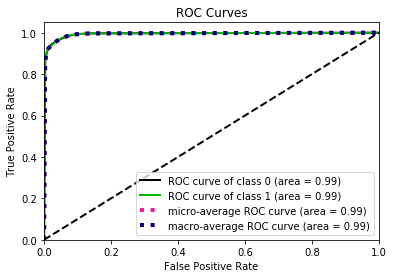

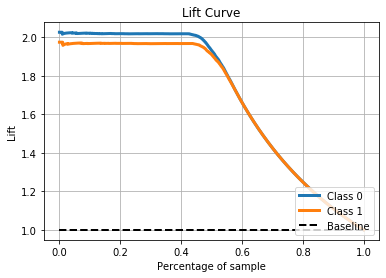

In [44]:
# knn
predicted_probas_knn = knn_cv.predict_proba(X_test)

# roc curve

skplt.metrics.plot_roc(Y_test, predicted_probas_knn)

# lift curve

skplt.metrics.plot_lift_curve(Y_test, predicted_probas_knn)

2. Random Forest

In [45]:
# random forest

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state=42, stratify = Y)


# random search

rf = RandomForestClassifier()
param_forest = {'n_estimators': np.arange(50,200), 'max_depth' : np.arange(3,20), 
                'min_samples_split':np.logspace(-2,0,10), 'criterion':['gini','entropy'],
                'min_samples_leaf' : np.arange(1,10), 'max_features':np.logspace(-2,0,10)}

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

rf_cv = RandomizedSearchCV(rf, param_forest, cv=inner_cv, scoring='roc_auc')
rf_cv.fit(X_train, Y_train)
print('best param is {0}'.format(rf_cv.best_params_))
print('best score is {0}'.format(rf_cv.best_score_))
print('-------------')


best param is {'n_estimators': 81, 'min_samples_split': 0.027825594022071243, 'min_samples_leaf': 5, 'max_features': 0.21544346900318834, 'max_depth': 11, 'criterion': 'entropy'}
best score is 0.9953380569904814
-------------


In [46]:
rf_score = cross_val_score(rf_cv, X=X_train, y=Y_train, cv=outer_cv, scoring='roc_auc')
rf_score

array([0.99565269, 0.9950431 , 0.99555418, 0.99496436])

In [47]:
Y_pred_rf = rf_cv.predict(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_rf)

print("The AUC is:", auc(fpr, tpr))
print('threshold:', thresholds)
print("")
print(classification_report(Y_test, Y_pred_rf))

The AUC is: 0.9612381139253322
threshold: [2 1 0]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10165
           1       0.96      0.96      0.96     10431

    accuracy                           0.96     20596
   macro avg       0.96      0.96      0.96     20596
weighted avg       0.96      0.96      0.96     20596



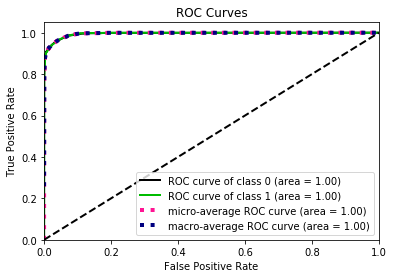

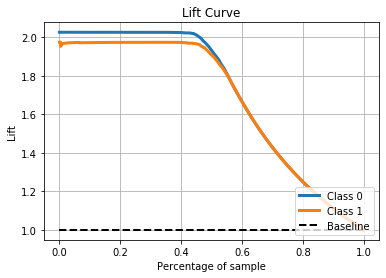

In [48]:
# rf
predicted_probas_rf = rf_cv.predict_proba(X_test)

# roc curve

skplt.metrics.plot_roc(Y_test, predicted_probas_rf)

# lift curve

skplt.metrics.plot_lift_curve(Y_test, predicted_probas_rf)

3. Neural network

In [77]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state=42, stratify = Y)

In [78]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',min_value=32,max_value=256,step=32),
                           activation=hp.Choice('activation', values = ['sigmoid','relu','tanh'])))
    
    for i in range(hp.Int('num_layers', 1, 20)):
        model.add(layers.Dense(256, activation=hp.Choice('activation', values = ['sigmoid','relu','tanh'])))
        #model.add(layers.Dropout(0.4))
    
    
    drop_rate = hp.Choice('drop_rate', values = [0.1,0.2,0.3,0.4])
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.SGD(
            hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy', 
        metrics=['accuracy'])
    return model


In [79]:
tuner = RandomSearch(
    build_model,
    objective=('val_accuracy'),
    max_trials=5,
    executions_per_trial=5,
    project_name='lol')

tuner.search(X_train, Y_train,
             epochs=5,
             validation_split=0.4,verbose = 2)

tuner.results_summary()

Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.2280 - accuracy: 0.8895 - val_loss: 0.0774 - val_accuracy: 0.9633
Epoch 2/5
18536/18536 - 4s - loss: 0.0690 - accuracy: 0.9675 - val_loss: 0.0742 - val_accuracy: 0.9642
Epoch 3/5
18536/18536 - 4s - loss: 0.0605 - accuracy: 0.9711 - val_loss: 0.0814 - val_accuracy: 0.9617
Epoch 4/5
18536/18536 - 3s - loss: 0.0567 - accuracy: 0.9736 - val_loss: 0.0928 - val_accuracy: 0.9628
Epoch 5/5
18536/18536 - 3s - loss: 0.0533 - accuracy: 0.9758 - val_loss: 0.0687 - val_accuracy: 0.9688
Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.2409 - accuracy: 0.8794 - val_loss: 0.0773 - val_accuracy: 0.9682
Epoch 2/5
18536/18536 - 4s - loss: 0.0685 - accuracy: 0.9671 - val_loss: 0.0736 - val_accuracy: 0.9660
Epoch 3/5
18536/18536 - 4s - loss: 0.0604 - accuracy: 0.9707 - val_loss: 0.0759 - val_accuracy: 0.9671
Epoch 4/5
18536/18536 - 3s - loss: 0.0562 - accuracy: 0.9735 - val_loss: 0.0

Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.6929 - accuracy: 0.5769 - val_loss: 0.6924 - val_accuracy: 0.6614
Epoch 2/5
18536/18536 - 4s - loss: 0.6919 - accuracy: 0.6617 - val_loss: 0.6912 - val_accuracy: 0.7602
Epoch 3/5
18536/18536 - 4s - loss: 0.6904 - accuracy: 0.7580 - val_loss: 0.6893 - val_accuracy: 0.7691
Epoch 4/5
18536/18536 - 4s - loss: 0.6878 - accuracy: 0.7970 - val_loss: 0.6858 - val_accuracy: 0.8246
Epoch 5/5
18536/18536 - 4s - loss: 0.6829 - accuracy: 0.8302 - val_loss: 0.6791 - val_accuracy: 0.8543
Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 5s - loss: 0.6926 - accuracy: 0.5117 - val_loss: 0.6919 - val_accuracy: 0.4913
Epoch 2/5
18536/18536 - 4s - loss: 0.6910 - accuracy: 0.6474 - val_loss: 0.6900 - val_accuracy: 0.7174
Epoch 3/5
18536/18536 - 4s - loss: 0.6885 - accuracy: 0.7736 - val_loss: 0.6869 - val_accuracy: 0.8597
Epoch 4/5
18536/18536 - 4s - loss: 0.6845 - accuracy: 0.8614 - val_loss: 0.6

Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 3s - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.4923
Epoch 2/5
18536/18536 - 2s - loss: 0.6926 - accuracy: 0.5068 - val_loss: 0.6925 - val_accuracy: 0.5022
Epoch 3/5
18536/18536 - 2s - loss: 0.6919 - accuracy: 0.5162 - val_loss: 0.6918 - val_accuracy: 0.5156
Epoch 4/5
18536/18536 - 2s - loss: 0.6912 - accuracy: 0.5358 - val_loss: 0.6911 - val_accuracy: 0.5380
Epoch 5/5
18536/18536 - 2s - loss: 0.6906 - accuracy: 0.5616 - val_loss: 0.6904 - val_accuracy: 0.5685
Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 3s - loss: 0.6914 - accuracy: 0.5035 - val_loss: 0.6912 - val_accuracy: 0.4998
Epoch 2/5
18536/18536 - 2s - loss: 0.6905 - accuracy: 0.5220 - val_loss: 0.6902 - val_accuracy: 0.5255
Epoch 3/5
18536/18536 - 2s - loss: 0.6895 - accuracy: 0.5590 - val_loss: 0.6892 - val_accuracy: 0.5792
Epoch 4/5
18536/18536 - 2s - loss: 0.6885 - accuracy: 0.6196 - val_loss: 0.6

Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.2692 - accuracy: 0.9039 - val_loss: 0.1589 - val_accuracy: 0.9350
Epoch 2/5
18536/18536 - 3s - loss: 0.1374 - accuracy: 0.9417 - val_loss: 0.1200 - val_accuracy: 0.9496
Epoch 3/5
18536/18536 - 3s - loss: 0.1080 - accuracy: 0.9546 - val_loss: 0.0990 - val_accuracy: 0.9561
Epoch 4/5
18536/18536 - 3s - loss: 0.0920 - accuracy: 0.9599 - val_loss: 0.0882 - val_accuracy: 0.9612
Epoch 5/5
18536/18536 - 3s - loss: 0.0829 - accuracy: 0.9625 - val_loss: 0.0826 - val_accuracy: 0.9629
Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.2502 - accuracy: 0.9083 - val_loss: 0.1528 - val_accuracy: 0.9364
Epoch 2/5
18536/18536 - 3s - loss: 0.1280 - accuracy: 0.9445 - val_loss: 0.1145 - val_accuracy: 0.9500
Epoch 3/5
18536/18536 - 3s - loss: 0.0994 - accuracy: 0.9565 - val_loss: 0.0948 - val_accuracy: 0.9587
Epoch 4/5
18536/18536 - 3s - loss: 0.0848 - accuracy: 0.9632 - val_loss: 0.0

Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 3s - loss: 0.1223 - accuracy: 0.9498 - val_loss: 0.0833 - val_accuracy: 0.9616
Epoch 2/5
18536/18536 - 2s - loss: 0.0765 - accuracy: 0.9680 - val_loss: 0.0739 - val_accuracy: 0.9681
Epoch 3/5
18536/18536 - 3s - loss: 0.0716 - accuracy: 0.9682 - val_loss: 0.0737 - val_accuracy: 0.9679
Epoch 4/5
18536/18536 - 3s - loss: 0.0684 - accuracy: 0.9702 - val_loss: 0.0827 - val_accuracy: 0.9629
Epoch 5/5
18536/18536 - 3s - loss: 0.0661 - accuracy: 0.9700 - val_loss: 0.0716 - val_accuracy: 0.9675
Train on 18536 samples, validate on 12358 samples
Epoch 1/5
18536/18536 - 4s - loss: 0.1189 - accuracy: 0.9507 - val_loss: 0.0833 - val_accuracy: 0.9631
Epoch 2/5
18536/18536 - 3s - loss: 0.0765 - accuracy: 0.9668 - val_loss: 0.0791 - val_accuracy: 0.9643
Epoch 3/5
18536/18536 - 3s - loss: 0.0704 - accuracy: 0.9675 - val_loss: 0.0816 - val_accuracy: 0.9637
Epoch 4/5
18536/18536 - 3s - loss: 0.0679 - accuracy: 0.9696 - val_loss: 0.0

INFO:tensorflow:Oracle triggered exit


In [71]:
model.layers

In [106]:

model = tuner.get_best_models(num_models=1)[0]

#loss, accuracy = model.evaluate(X_test, Y_test)

Y_pred_nn = model.predict(X_test)

In [107]:
print('AUC based on probab:',roc_auc_score(Y_test,Y_pred_nn))

AUC based on probab: 0.997320927918187


In [110]:
# transform probab output to binary class 

Y_pred_nn_class = np.where(Y_pred_nn>=0.5,1,0)

model comparison

In [125]:
# compare based on the output class for test auc and f1

com = pd.DataFrame({'Model':['knn','Random Forest','Neural Network'], 
                    'Test_auc':[auc(roc_curve(Y_test, Y_pred_knn)[0],roc_curve(Y_test, Y_pred_knn)[1]), 
                                auc(roc_curve(Y_test, Y_pred_rf)[0],roc_curve(Y_test, Y_pred_rf)[1]),
                                roc_auc_score(Y_test,Y_pred_nn_class)],
                    'F1_score':[f1_score(Y_test, Y_pred_knn),
                                f1_score(Y_test, Y_pred_rf),
                                f1_score(Y_test, Y_pred_nn_class)]})
com

,Model,Test_auc,F1_score
0,knn,0.960969,0.961424
1,Random Forest,0.961238,0.961778
2,Neural Network,0.970259,0.970867


# Best model: Neural Network 